In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda, Dense, Input

from keras.callbacks import ModelCheckpoint 

from keras import optimizers
from keras import backend as K
from keras import regularizers

#from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files 
from tqdm import tqdm

# Add real time loss and accuracy plot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


# Load and examine the dataset

In [2]:
def load_dataset(path):
    # the sklearn.datasets.load_files function takes a dataset directory as an input
    # for each folder within the directory, the folder name should be a category
    # within each folder will be samples corresponding to their category
    # load_files returns a bunch object which is a dictionary with 'DESC', 
    # 'data', 'filenames', 'target' as keys
    data = load_files(path)
    # an array of file paths or directories
    data_files = np.array(data['filenames']) 
    data_labels = np_utils.to_categorical(np.array(data['target']), 10)
    return data_files, data_labels

In [3]:
train_data_dir = "train/"
faked_data_dir = "faked/"
data_directory = faked_data_dir

In [4]:
train_files, train_labels = load_dataset(data_directory)
print("There are {} total training images.".format(len(train_files)))

There are 20 total training images.


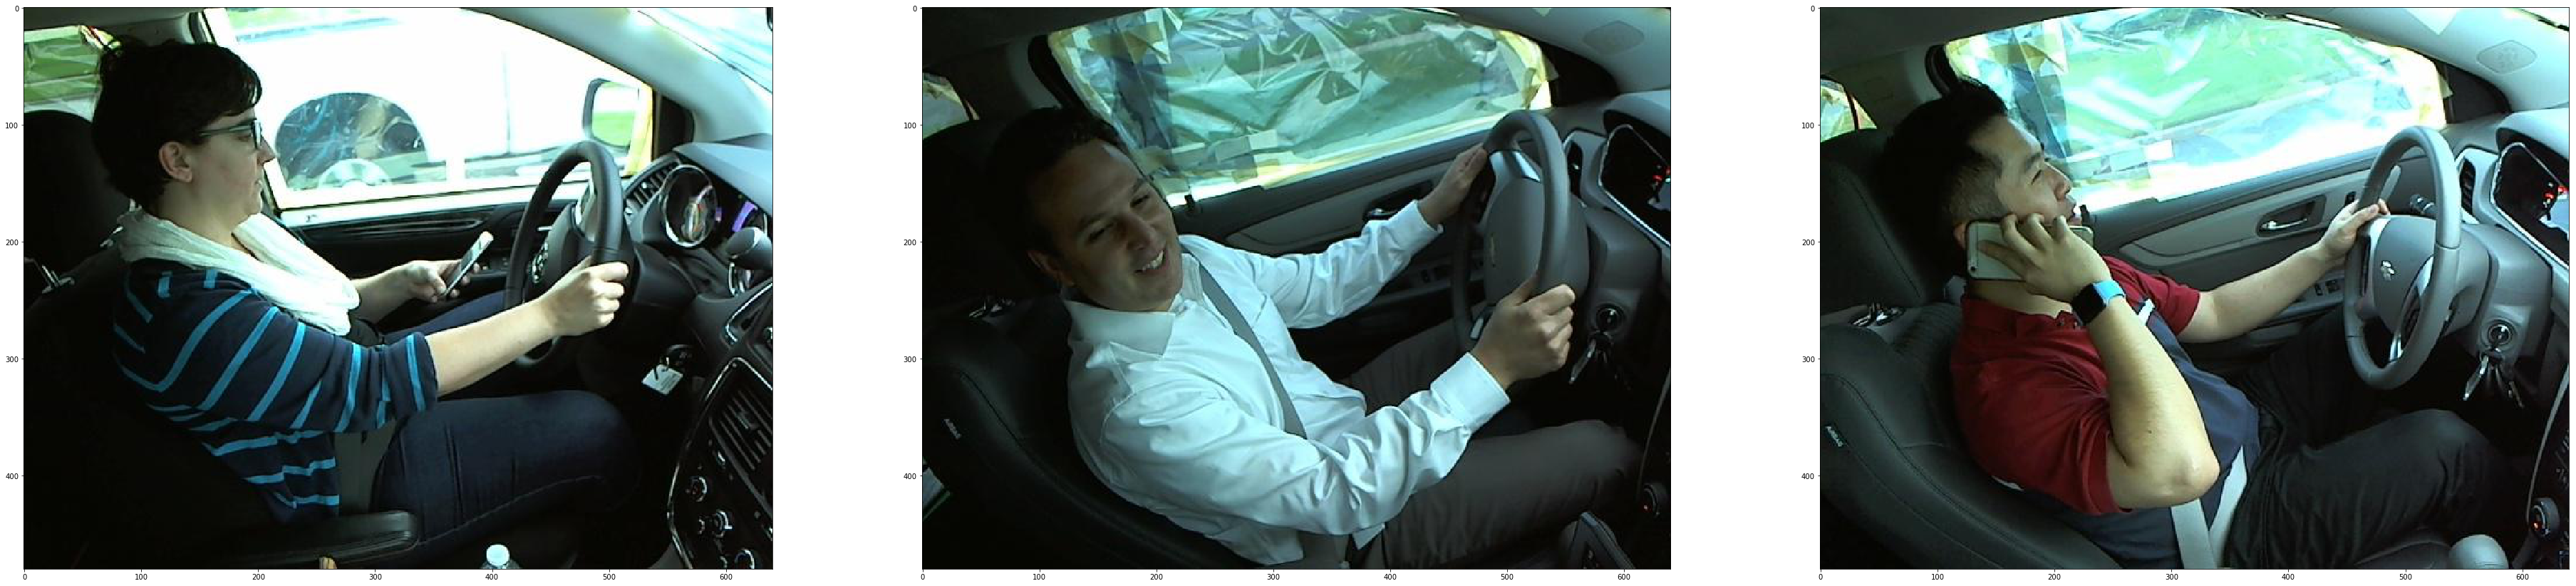

In [16]:
# Random visualize some image data
samples = np.random.choice(train_files, 3)
imgs = []
for sample in samples: 
    img = mpimg.imread(sample)
    imgs.append(img)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(64, 48))
ax1.imshow(imgs[0])
ax2.imshow(imgs[1])
ax3.imshow(imgs[2])
plt.show()

# Model building

I want to use transfer learning to boost the performance, and to obtain a proper weighted top layer, I have to get the bottleneck features from current dataset and then train the top layer with bottleneck features as inputs, then after that, finetune the model.

>In order to perform fine-tuning, all layers should start with properly trained weights: for instance you should not slap a randomly initialized fully-connected network on top of a pre-trained convolutional base. This is because the large gradient updates triggered by the randomly initialized weights would wreck the learned weights in the convolutional base. In our case this is why we first train the top-level classifier, and only then start fine-tuning convolutional weights alongside it.  ---- Keras Blog

### InceptionV3

In [5]:
# Hyperparameters setting
batch_size = 64
bottleneck_epochs = 5
finetune_epochs = 5
target_size = (299, 299)

In [18]:
# This cell demonstrate how to split the dataset with Sklearn, but I prefer ImageDataGenerator
# X_train, X_valid, y_train, y_valid = train_test_split(train_files, train_labels, test_size=0.2)

In [19]:
#y_train

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)

In [6]:
# Helper functions to process the training and validation data
def path_to_tensor(img_path, target_size=target_size):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, target_size=target_size):
    list_of_tensors = [path_to_tensor(path, target_size=target_size) for path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [21]:
#X_train_data = paths_to_tensor(X_train, target_size=target_size)
#X_valid_data = paths_to_tensor(X_valid, target_size=target_size)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 145.73it/s]


In [22]:
#X_train_data = preprocess_input(X_train_data)
#X_valid_data = preprocess_input(X_valid_data)

In [24]:
#bottleneck_features_train = InceptionV3_model.predict(X_train_data, verbose=1)
#bottleneck_features_validation = InceptionV3_model.predict(X_valid_data, verbose=1)

#np.savez('bottleneck_features_train.npz', 
#         train=bottleneck_features_train, 
#         validation=bottleneck_features_validation)

4/4 [==============================] - 4s 1s/step


In [25]:
#bottleneck_features = np.load('bottleneck_features_train.npz')
#train_data = bottleneck_features['train']
#validation_data = bottleneck_features['validation']

In [7]:
# Here I want to try real time data augumentation with keras
# `validation_split` is only support in Keras 2.2.0 
train_valid_datagen = ImageDataGenerator(zoom_range=0.2, 
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   preprocessing_function=preprocess_input, 
                                   validation_split=0.2)

In [8]:
# `subset` is only possible if `validation_split` is set
train_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="training",
                                                    shuffle=True)

Found 20 images belonging to 10 classes.


In [9]:
# `subset` is only possible if `validation_split` is set
validation_generator = train_valid_datagen.flow_from_directory(data_directory, 
                                                    target_size=target_size, 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size, 
                                                    subset="validation",
                                                    shuffle=False)

Found 0 images belonging to 10 classes.


In [10]:
# Better provide the input shape to made the model summary more readible
input_tensor = Input(shape=(299, 299, 3))

InceptionV3_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = InceptionV3_base.output
# The input shape from bottleneck_feature is (data_size, 8, 8, 2048)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(10, name='top', kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01))(x)
# I use below line instead of normal softmax to bypass the compatibility issues.
predictions = Lambda(lambda x: K.tf.nn.softmax(x))(x)

InceptionV3_model = Model(inputs=InceptionV3_base.input, outputs=predictions)

for layer in InceptionV3_base.layers:
    layer.trainable = False

InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 35, 35, 256)  0           activation_6[0][0]               
                                                                 activation_8[0][0]               
                                                                 activation_11[0][0]              
                                                                 activation_12[0][0]              
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 35, 35, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 35, 35, 64)   192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 35, 35, 64)   192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 35, 35, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 35, 35, 96)   288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 35, 35, 64)   192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 35, 35, 64)   0           batch_normalization_20[0][0]     
__________

batch_normalization_38 (BatchNo (None, 17, 17, 128)  384         conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 17, 17, 128)  0           batch_normalization_33[0][0]     
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 17, 17, 128)  0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 17, 17, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_34 

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, 17, 17, 192)  576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 17, 17, 192)  576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 17, 17, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 17, 17, 192)  576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 17, 17, 192)  0           batch_normalization_41[0][0]     
__________

activation_60 (Activation)      (None, 17, 17, 192)  0           batch_normalization_60[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 17, 17, 768)  0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 17, 17, 192)  576         conv2d_65[0][0]                  
__________

batch_normalization_74 (BatchNo (None, 17, 17, 192)  576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, 17, 17, 192)  0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 17, 17, 192)  258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 17, 17, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_84 (Activation)      (None, 8, 8, 384)    0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 8, 8, 192)    576         conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 8, 8, 320)    0           batch_normalization_77[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 8, 8, 768)    0           activation_79[0][0]              
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 8, 8, 768)    0           activation_83[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1024)         2098176     global_average_pooling2d_1[0][0] 
__________________________________________________________________________________________________
top (Dense)                     (None, 10)           10250       dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

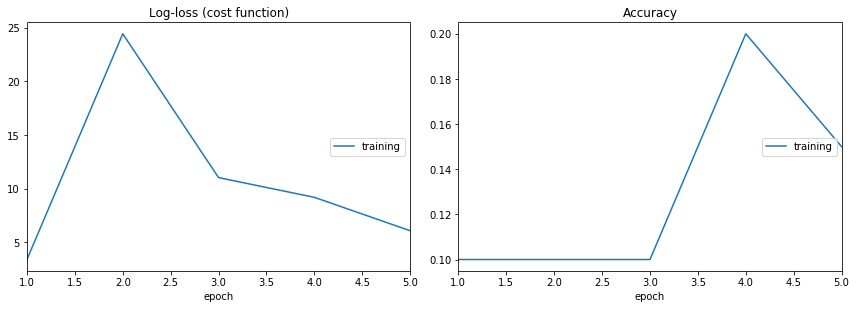

In [11]:
# Compile the mode, with optimizer as `rmsprop`
InceptionV3_model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Set checkpointer for training callbacks
checkpointer = ModelCheckpoint(filepath='bottleneck_weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)

history = InceptionV3_model.fit_generator(train_generator,
                    validation_data=validation_generator, 
                    epochs=bottleneck_epochs, 
                    callbacks=[checkpointer, PlotLossesKeras()], 
                    verbose=0)

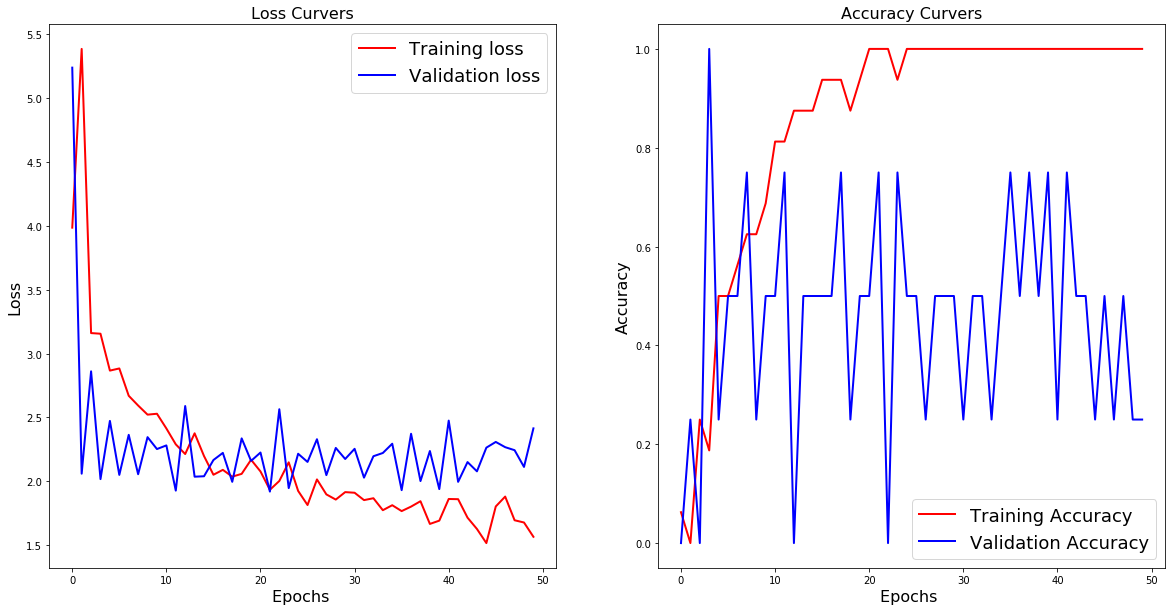

In [29]:
# Visualizing the losses and accuracies

# Loss Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(history.history['loss'], 'r', linewidth=2.0)
ax1.plot(history.history['val_loss'], 'b', linewidth=2.0)
ax1.legend(['Training loss', 'Validation loss'], fontsize=18)
ax1.set_xlabel('Epochs ', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Loss Curvers', fontsize=16)

# Accuracy Curves
ax2.plot(history.history['acc'], 'r', linewidth=2.0)
ax2.plot(history.history['val_acc'], 'b', linewidth=2.0)
ax2.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
ax2.set_xlabel('Epochs ', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set_title('Accuracy Curvers', fontsize=16);

In [30]:
# This cell is just to illustrate how to examine the training result manually
#model.load_weights('saved_models/bottleneck_weights.best.hdf5')
# get index of predictions each image in test set
#predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in validation_data]

# report test accuracy
#validation_accuracy = 100 * np.sum(np.array(predictions)==np.argmax(y_valid, axis=1))/len(predictions)

#print("Test accuracy: {:.4f}%".format(validation_accuracy))

# Finetuning the model 

I run into [this link](https://keras.io/applications/) and rewrite my finetuning model as below

In [21]:
for layer in InceptionV3_model.layers[:249]:
    layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
    layer.trainable=True

InceptionV3_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 

__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 35, 35, 64)   192         conv2d_114[0][0]                 
__________________________________________________________________________________________________
batch_normalization_116 (BatchN (None, 35, 35, 64)   192         conv2d_116[0][0]                 
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 35, 35, 96)   288         conv2d_119[0][0]                 
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 35, 35, 64)   192         conv2d_120[0][0]                 
__________________________________________________________________________________________________
activation_114 (Activation)     (None, 35, 35, 64)   0           batch_normalization_114[0][0]    
__________

__________________________________________________________________________________________________
batch_normalization_135 (BatchN (None, 17, 17, 192)  576         conv2d_135[0][0]                 
__________________________________________________________________________________________________
batch_normalization_138 (BatchN (None, 17, 17, 192)  576         conv2d_138[0][0]                 
__________________________________________________________________________________________________
batch_normalization_143 (BatchN (None, 17, 17, 192)  576         conv2d_143[0][0]                 
__________________________________________________________________________________________________
batch_normalization_144 (BatchN (None, 17, 17, 192)  576         conv2d_144[0][0]                 
__________________________________________________________________________________________________
activation_135 (Activation)     (None, 17, 17, 192)  0           batch_normalization_135[0][0]    
__________

batch_normalization_168 (BatchN (None, 17, 17, 192)  576         conv2d_168[0][0]                 
__________________________________________________________________________________________________
activation_168 (Activation)     (None, 17, 17, 192)  0           batch_normalization_168[0][0]    
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_169 (Conv2D)             (None, 17, 17, 192)  258048      activation_168[0][0]             
__________________________________________________________________________________________________
batch_normalization_165 (BatchN (None, 17, 17, 192)  576         conv2d_165[0][0]                 
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_4[0][0]              
                                                                 activation_188[0][0]             
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         2098176     global_average_pooling2d_3[0][0] 
__________________________________________________________________________________________________
top (Dense)                     (None, 10)           10250       dense_3[0][0]                    
__________________________________________________________________________________________________
lambda_3 (

In [22]:
# Train the model with SGD and small learning rate to REALLY FINETUNE
InceptionV3_model.compile(optimizer=optimizers.SGD(lr=1e-5, momentum=0.5), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='saved_models/finetuning_weights.best.hdf5', 
                               verbose=1, save_best_only=True)

tuning_history = InceptionV3_model.fit_generator(train_generator, 
                            epochs=finetune_epochs, 
                            validation_data=validation_generator, 
                            callbacks=[checkpointer], 
                            verbose=1)

Epoch 1/5
1/1 [==============================] - 22s 22s/step - loss: 3.3175 - acc: 0.1000


c:\programdata\anaconda3\envs\gym\lib\site-packages\keras\callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/5
1/1 [==============================] - 16s 16s/step - loss: 3.3498 - acc: 0.1000
Epoch 3/5
1/1 [==============================] - 18s 18s/step - loss: 3.3336 - acc: 0.1000
Epoch 4/5
1/1 [==============================] - 17s 17s/step - loss: 3.3631 - acc: 0.1000
Epoch 5/5
1/1 [==============================] - 17s 17s/step - loss: 3.4403 - acc: 0.1000


In [ ]:
# Visualizing the losses and accuracies

# Loss Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(tuning_history.history['loss'], 'r', linewidth=2.0)
ax1.plot(tuning_history.history['val_loss'], 'b', linewidth=2.0)
ax1.legend(['Training loss', 'Validation loss'], fontsize=18)
ax1.set_xlabel('Epochs ', fontsize=16)
ax1.set_ylabel('Loss', fontsize=16)
ax1.set_title('Loss Curvers', fontsize=16)

# Accuracy Curves
ax2.plot(tuning_history.history['acc'], 'r', linewidth=2.0)
ax2.plot(tuning_history.history['val_acc'], 'b', linewidth=2.0)
ax2.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
ax2.set_xlabel('Epochs ', fontsize=16)
ax2.set_ylabel('Accuracy', fontsize=16)
ax2.set_title('Accuracy Curvers', fontsize=16);

## Ensemble models

I personally don't like the idea of Ensemble since it is more of a competition wining skills which only add the complexity of the model and can hardly be used in production. However, as a learning experience, I want to give it a try. 

In [40]:
from keras.applications.inception_v3 import preprocess_input as Inception_preprocess
from keras.applications.resnet50 import preprocess_input as Resnet_preprocess
from glob import glob
from collections import defaultdict
import pandas as pd

img_names = [item[5:] for item in sorted(glob('test/*'))]
img_directory = [item for item in sorted(glob('test/*'))]

Inception_data = paths_to_tensor(img_directory, target_size=(299, 299))
Resnet50_data = paths_to_tensor(img_directory, target_size=(224, 224))

Inception_input = Inception_preprocess(Inception_data)
Resnet50_input = Resnet_preprocess(Resnet50_data)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 154.14it/s]


(2, 299, 299, 3)
(2, 299, 299, 3)


In [42]:
# Obtain the ensembled predictions
# Here I used tuning twice for test's sake

predictions = defaultdict(np.array)

for img_name, inception, resnet in zip(img_names, Inception_input, Resnet50_input):
    Inception_output = InceptionV3_model.predict(np.expand_dims(inception, 0))
    Resnet_output = resnet_tuning.predict(np.expand_dims(inception, 0))
    ensembled = np.mean(np.vstack((Inception_output, Resnet_output)), axis=0)
    predictions[img_name] = ensembled

defaultdict(<built-in function array>, {'img_31.jpg': array([ 0.13722385,  0.11507343,  0.07817094,  0.14049868,  0.03330261,
        0.05885539,  0.01891165,  0.15590698,  0.01367622,  0.2483802 ], dtype=float32), 'img_1.jpg': array([ 0.10607031,  0.08703807,  0.07396737,  0.18341088,  0.12719008,
        0.09078396,  0.0605133 ,  0.06878687,  0.06964184,  0.13259728], dtype=float32)})


In [55]:
# Write out the data according to submission request format

data = pd.DataFrame(predictions, index=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
data = data.transpose()
data

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_1.jpg,0.106070,0.087038,0.073967,0.183411,0.127190,0.090784,0.060513,0.068787,0.069642,0.132597
img_31.jpg,0.137224,0.115073,0.078171,0.140499,0.033303,0.058855,0.018912,0.155907,0.013676,0.248380


In [ ]:
data.to_csv("my data.csv")